In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
from torchvision.models import resnet18
import torchaudio.transforms as T
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')
data_dir = '/kaggle/input/free-spoken-digits/free-spoken-digit-dataset-master/recordings'

In [4]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [5]:
NUM_SAMPLES = 11022
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
random_seed = 23
train_size = 0.8

In [6]:
recordings_old = sorted(os.listdir(data_dir))

In [7]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [8]:
len(recordings)

2903

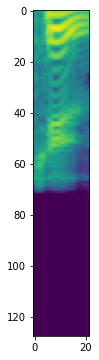

In [9]:
y, _ = librosa.load(data_dir + '/' + recordings[700], sr = sr)
samples = y[:NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec, ref=np.max)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [10]:
image_size = melspec.shape
image_size

(128, 22)

In [11]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def freq_shift_augmentation(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = 0.0
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = 0.0
    return image

def random_erasing(image, max_a = 12, max_b = 2):
    a = np.random.randint(max_a)
    b = np.random.randint(max_b)
    a0 = np.random.randint(image.shape[1] - a)
    b0 = np.random.randint(image.shape[2] - b)
    image[:, a0 : a0 + a, b0 : b0 + b] = 0.0
    return image

def loudness_conrol(image):
    min_value = torch.min(image)
    lyambda = np.random.rand() * 0.4
    image = min_value + lyambda * (image - min_value)
    return image
    
def FreqNoising(image, var = 0.1, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(image.shape[1] - a)
    noise = var * torch.randn(a, image.shape[2])
    image[0, a0: a0 + a, :] += noise
    image[1, a0: a0 + a, :] += noise
    image[2, a0: a0 + a, :] += noise
    return image

def TimeNoising(image, var = 0.1, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(image.shape[2] - b)
    noise = var * torch.randn(image.shape[1], b)
    image[0, :, b0: b0 + b] += noise
    image[1, :, b0: b0 + b] += noise
    image[2, :, b0: b0 + b] += noise
    return image

def TimeCycleShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def FreqCycleShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, image.shape[1] - shift:, :].clone()
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
        image[:, :shift, :] = t
    else:
        t = image[:, :shift, :].clone()
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
        image[:, image.shape[1] - shift:, :] = t
    return image

def TimeSpecialShift(image, max_shift = 2):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
    return image

def FreqSpecialShift(image, max_shift = 12):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, shift:, :] = image[:, :image.shape[1] - shift, :]
    else:
        image[:, :image.shape[1] - shift, :] = image[:, shift:, :]
    return image

def FreqSwapAugmentation(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - a)
    t = image[:, a0 : a0 + a, :].clone()
    image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    image[:, a0 - a: a0, :] = t
    return image

def TimeSwapAugmentation(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def FreqReplyMasking(image, max_a = 12):
    a = np.random.randint(max_a)
    a0 = np.random.randint(a, image.shape[1] - 2 * a)
    p = np.random.rand()
    if p < 0.5:
        image[:, a0 : a0 + a, :] = image[:, a0 - a: a0, :]
    else:
        image[:,  a0 : a0 + a, :] = image[:, a0 + a : a0 + 2 * a, :]
    return image

def TimeReplyMasking(image, max_b = 2):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 2):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def FreqRandomSwap(image, max_a = 12):
    a = np.random.randint(max_a)
    a1 = np.random.randint(image.shape[1] - a)
    while True:
        a2 = np.random.randint(image.shape[1] - a)
        if np.abs(a1 - a2) >= a:
            t = image[:, a1 : a1 + a, :].clone()
            image[:, a1 : a1 + a, :] = image[:, a2 : a2 + a, :]
            image[:, a2 : a2 + a, :] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(2)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(12)(image)
    if mode == 'RandomErasing':
        return random_erasing(image, 12, 2)
    if mode == 'FreqShift':
        return freq_shift_augmentation(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'LoudnessControl':
        return loudness_conrol(image)
    if mode == 'TimeNoising':
        return TimeNoising(image)
    if mode == 'FreqNoising':
        return FreqNoising(image)
    if mode == 'FreqCycleShift':
        return FreqCycleShift(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'FreqSpecialShift':
        return FreqSpecialShift(image)
    if mode == 'TimeSpecialShift':
        return TimeSpecialShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'FreqSwapAugmentation':
        return FreqSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'FreqReplyMasking':
        return FreqReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)
    if mode == 'FreqRandomSwap':
        return FreqRandomSwap(image)
    
    
    return image

In [12]:
def get_spectrogram(filename):
    y, _ = librosa.load(filename, sr = sr)
    samples = y[:NUM_SAMPLES]
    melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
    melspec = librosa.power_to_db(melspec)
    melspec = normalize(melspec, mean=None, std=None)
    return torch.tensor(melspec, dtype=torch.float32)

In [13]:
data = []
labels = []
for i in range(len(recordings)):
    data.append(get_spectrogram(data_dir + '/' + recordings[i]))
    labels.append(int(recordings[i][0]))

In [14]:
keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

In [15]:
class AudioMNIST(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = [], augment = False, aug_type = 'No'):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        self.augment = augment
        self.aug_type = aug_type
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        if self.augment:
            X = augmentation(X, self.aug_type)
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, augment = 'No'):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    for epoch in range(epochs):
        print('epoch:', epoch)
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)

        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        print('Train')
        print(mean_loss)

        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)

        print('TEST')
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
        print('loss:', mean_loss)
        print('accuracy:', mean_accuracy)
        print('******************')
    print('Accuracy on the validation: ', best_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, valid_losses, valid_acc

In [17]:
def evaluate(model, test_loader):
    model.eval()
    #all_preds = []
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)
            #all_preds.append(preds)

    mean_accuracy = sum_accuracy / cnt_objects
    print('Quality of the model')
    print('accuracy:', mean_accuracy)

## Resnet18

### No augmentation

In [18]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = False, keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch: 0
Train
1.0194161785631073
TEST
loss: 0.8254843291415963
accuracy: 0.7591397849462366
******************
epoch: 1
Train
0.342624960885487
TEST
loss: 0.24858470424529044
accuracy: 0.9139784946236559
******************
epoch: 2
Train
0.2808378798125826
TEST
loss: 0.2700828132249655
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.2394576054477666
TEST
loss: 1.0885942533452024
accuracy: 0.7591397849462366
******************
epoch: 4
Train
0.2359490514154645
TEST
loss: 0.740536615829314
accuracy: 0.8064516129032258
******************
epoch: 5
Train
0.1748443736253917
TEST
loss: 0.21111317808910082
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.15789440436329838
TEST
loss: 0.36616805064421826
accuracy: 0.8924731182795699
******************
epoch: 7
Train
0.18284759361158473
TEST
loss: 0.6030740173273189
accuracy: 0.843010752688172
******************
epoch: 8
Train
0.12035875647907046
TEST
loss: 0.22667371060258598
accuracy: 0.9311827956989247
********

In [19]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


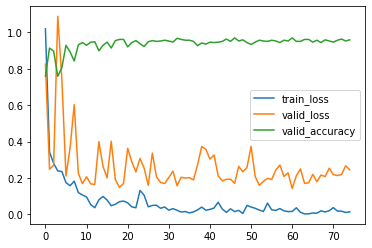

In [20]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeMasking

In [21]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9972137049057179
TEST
loss: 0.3290728281101873
accuracy: 0.8924731182795699
******************
epoch: 1
Train
0.4154574546238782
TEST
loss: 1.01982273363298
accuracy: 0.7913978494623656
******************
epoch: 2
Train
0.31024655585784583
TEST
loss: 0.2956278021617602
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.1992057865514637
TEST
loss: 0.2044696258601322
accuracy: 0.9204301075268817
******************
epoch: 4
Train
0.21148764010264018
TEST
loss: 0.2003398390867377
accuracy: 0.9290322580645162
******************
epoch: 5
Train
0.2316493731900833
TEST
loss: 0.27123824318730705
accuracy: 0.9182795698924732
******************
epoch: 6
Train
0.1577785673100395
TEST
loss: 0.18795108234469768
accuracy: 0.9376344086021505
******************
epoch: 7
Train
0.11492556452301798
TEST
loss: 0.20256138104264454
accuracy: 0.9397849462365592
******************
epoch: 8
Train
0.12286671600918905
TEST
loss: 0.2551395077538747
accura

In [22]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9449225473321858


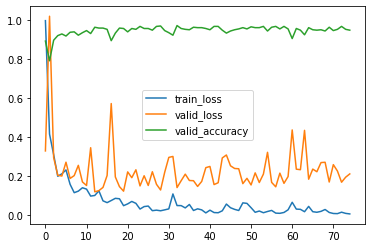

In [23]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqMasking

In [24]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.997173272927859
TEST
loss: 0.34137922778565394
accuracy: 0.8838709677419355
******************
epoch: 1
Train
0.478554614975559
TEST
loss: 0.7203348614836251
accuracy: 0.8
******************
epoch: 2
Train
0.3289065402107465
TEST
loss: 0.45184523155612333
accuracy: 0.8580645161290322
******************
epoch: 3
Train
0.2682854516825884
TEST
loss: 0.27427520995498983
accuracy: 0.9010752688172043
******************
epoch: 4
Train
0.24826199220725137
TEST
loss: 0.5241092994979393
accuracy: 0.8602150537634409
******************
epoch: 5
Train
0.22365791048487477
TEST
loss: 0.21834283240379826
accuracy: 0.9118279569892473
******************
epoch: 6
Train
0.17338953814361452
TEST
loss: 0.2062134705243572
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.17811430181042123
TEST
loss: 0.5589447998551912
accuracy: 0.9075268817204301
******************
epoch: 8
Train
0.21982009493027185
TEST
loss: 0.26960166545724995
accuracy: 0.91612

In [25]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


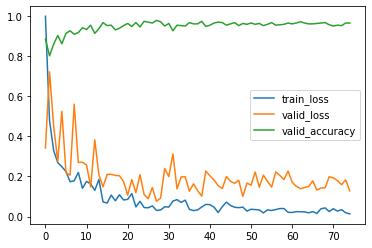

In [26]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### Noise

In [27]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'Noise', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9054087621265672
TEST
loss: 0.44429021256585277
accuracy: 0.8731182795698925
******************
epoch: 1
Train
0.34106872154938384
TEST
loss: 0.7129252567086168
accuracy: 0.7956989247311828
******************
epoch: 2
Train
0.29598343712576114
TEST
loss: 0.5235022693551997
accuracy: 0.8623655913978494
******************
epoch: 3
Train
0.2197682708261086
TEST
loss: 0.29247182517923337
accuracy: 0.9247311827956989
******************
epoch: 4
Train
0.19465954989339307
TEST
loss: 0.15771013105748802
accuracy: 0.9505376344086022
******************
epoch: 5
Train
0.12636822386452698
TEST
loss: 0.1610028169167939
accuracy: 0.946236559139785
******************
epoch: 6
Train
0.15626695797080048
TEST
loss: 0.26612606676675943
accuracy: 0.9290322580645162
******************
epoch: 7
Train
0.16004080841730023
TEST
loss: 0.5511547059782089
accuracy: 0.8666666666666667
******************
epoch: 8
Train
0.14239609476598156
TEST
loss: 0.22631525191909044

In [28]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9345955249569707


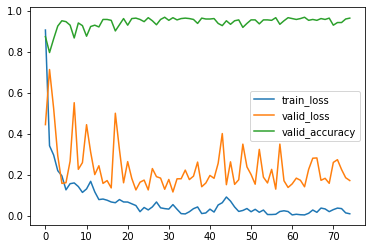

In [29]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### RandomErasing

In [30]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'RandomErasing', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9426532648042382
TEST
loss: 0.500857739615184
accuracy: 0.8709677419354839
******************
epoch: 1
Train
0.33251455938167707
TEST
loss: 0.4016433537006378
accuracy: 0.8946236559139785
******************
epoch: 2
Train
0.3420105295022072
TEST
loss: 0.23386499631789423
accuracy: 0.9139784946236559
******************
epoch: 3
Train
0.22220057621397635
TEST
loss: 0.5441734884374885
accuracy: 0.8365591397849462
******************
epoch: 4
Train
0.17784203681242228
TEST
loss: 0.2522724374648063
accuracy: 0.9096774193548387
******************
epoch: 5
Train
0.1514665376421066
TEST
loss: 0.25067567524890744
accuracy: 0.9290322580645162
******************
epoch: 6
Train
0.16295242222907663
TEST
loss: 0.28104927520598133
accuracy: 0.9225806451612903
******************
epoch: 7
Train
0.21851150925819374
TEST
loss: 0.37211059594667084
accuracy: 0.8881720430107527
******************
epoch: 8
Train
0.14037489704085604
TEST
loss: 0.16246067243578133


In [31]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9569707401032702


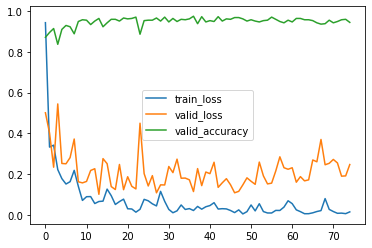

In [32]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeShift

In [33]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.03402021378038
TEST
loss: 0.6062079024571244
accuracy: 0.8129032258064516
******************
epoch: 1
Train
0.37554975177372535
TEST
loss: 0.3885524293427826
accuracy: 0.8623655913978494
******************
epoch: 2
Train
0.3678177766538013
TEST
loss: 0.37108080016989864
accuracy: 0.9075268817204301
******************
epoch: 3
Train
0.27746497308880524
TEST
loss: 0.5716417269040179
accuracy: 0.843010752688172
******************
epoch: 4
Train
0.2675451835317514
TEST
loss: 0.30422235016701044
accuracy: 0.9010752688172043
******************
epoch: 5
Train
0.22589139089060523
TEST
loss: 0.17939378921222943
accuracy: 0.9354838709677419
******************
epoch: 6
Train
0.20126202707336868
TEST
loss: 0.23430693518089993
accuracy: 0.9397849462365592
******************
epoch: 7
Train
0.1565947441156506
TEST
loss: 0.2002619648472436
accuracy: 0.9376344086021505
******************
epoch: 8
Train
0.14112369227486396
TEST
loss: 0.11382858590573393
acc

In [34]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9604130808950087


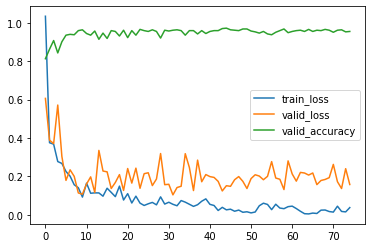

In [35]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqShift

In [36]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.91863739856418
TEST
loss: 4.011157081973169
accuracy: 0.37849462365591396
******************
epoch: 1
Train
1.3469523529115388
TEST
loss: 0.6245010429813016
accuracy: 0.8150537634408602
******************
epoch: 2
Train
1.2331756615934029
TEST
loss: 0.7017276625479422
accuracy: 0.789247311827957
******************
epoch: 3
Train
1.1329480705559094
TEST
loss: 0.7100197238306846
accuracy: 0.8193548387096774
******************
epoch: 4
Train
1.061441609855615
TEST
loss: 0.5011398127643011
accuracy: 0.8150537634408602
******************
epoch: 5
Train
0.9706139127991182
TEST
loss: 0.4416382865239215
accuracy: 0.8623655913978494
******************
epoch: 6
Train
1.0424156479124234
TEST
loss: 0.4430438858206554
accuracy: 0.853763440860215
******************
epoch: 7
Train
0.9378538817632692
TEST
loss: 0.24024678795568405
accuracy: 0.9096774193548387
******************
epoch: 8
Train
0.9413305443335941
TEST
loss: 0.2636505726865062
accuracy: 0.91

In [37]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9328743545611016


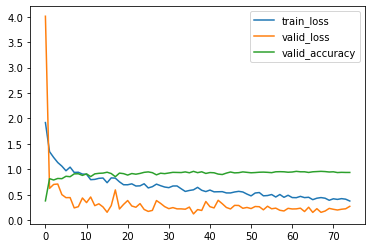

In [38]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### LoudnessControl

In [39]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'LoudnessControl', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.5062740081474868
TEST
loss: 1.5688539789568994
accuracy: 0.513978494623656
******************
epoch: 1
Train
0.6551108466853489
TEST
loss: 1.01292672118833
accuracy: 0.6516129032258065
******************
epoch: 2
Train
0.567238138257398
TEST
loss: 0.7036340155909139
accuracy: 0.7612903225806451
******************
epoch: 3
Train
0.3986403729142716
TEST
loss: 1.2167297670918127
accuracy: 0.6365591397849463
******************
epoch: 4
Train
0.3923921260258557
TEST
loss: 0.5208361407761932
accuracy: 0.832258064516129
******************
epoch: 5
Train
0.31418445730440453
TEST
loss: 0.38697569818906885
accuracy: 0.8688172043010752
******************
epoch: 6
Train
0.2969070730122046
TEST
loss: 0.3314404350455089
accuracy: 0.8989247311827957
******************
epoch: 7
Train
0.274886657377052
TEST
loss: 0.29979132298500305
accuracy: 0.9032258064516129
******************
epoch: 8
Train
0.24381839356389684
TEST
loss: 0.43643751612273596
accuracy: 0

In [40]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9208261617900172


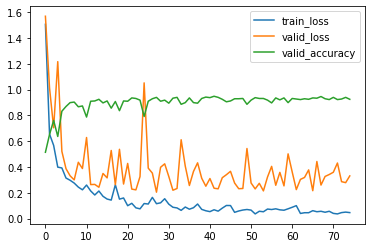

In [41]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeNoising

In [42]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9757893636269023
TEST
loss: 0.4969666557286375
accuracy: 0.8473118279569892
******************
epoch: 1
Train
0.36110227128543965
TEST
loss: 0.38694033956014984
accuracy: 0.8688172043010752
******************
epoch: 2
Train
0.2466422973554752
TEST
loss: 0.3351669028882057
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.19875213296810143
TEST
loss: 0.8653269716488418
accuracy: 0.789247311827957
******************
epoch: 4
Train
0.18355689174909393
TEST
loss: 0.5601175942087686
accuracy: 0.853763440860215
******************
epoch: 5
Train
0.2041160868391531
TEST
loss: 0.16719371200168645
accuracy: 0.9440860215053763
******************
epoch: 6
Train
0.12526471071109763
TEST
loss: 0.21649594837298958
accuracy: 0.9354838709677419
******************
epoch: 7
Train
0.11600756031342199
TEST
loss: 0.11690191010173451
accuracy: 0.956989247311828
******************
epoch: 8
Train
0.12372563562296254
TEST
loss: 0.24795516414507743
acc

In [43]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.963855421686747


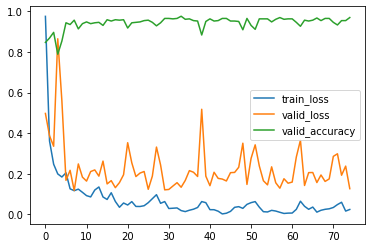

In [44]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqNoising

In [45]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqNoising', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9071127578142707
TEST
loss: 0.4917776544568359
accuracy: 0.8408602150537634
******************
epoch: 1
Train
0.36610219590305704
TEST
loss: 0.637087066711918
accuracy: 0.8064516129032258
******************
epoch: 2
Train
0.30841357700273947
TEST
loss: 0.38399635298598195
accuracy: 0.8924731182795699
******************
epoch: 3
Train
0.2188658181479623
TEST
loss: 0.2879013767646205
accuracy: 0.9096774193548387
******************
epoch: 4
Train
0.18781333799861616
TEST
loss: 0.23505387546554687
accuracy: 0.9161290322580645
******************
epoch: 5
Train
0.15892597492112226
TEST
loss: 0.17901956451836454
accuracy: 0.9354838709677419
******************
epoch: 6
Train
0.14553273290668564
TEST
loss: 0.23412988601673035
accuracy: 0.9204301075268817
******************
epoch: 7
Train
0.10862603847802038
TEST
loss: 0.2725841951306148
accuracy: 0.9161290322580645
******************
epoch: 8
Train
0.12300584891757851
TEST
loss: 0.5215169706652242


In [46]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.955249569707401


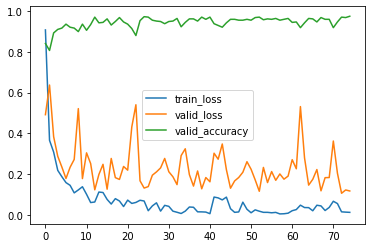

In [47]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeCycleShift

In [48]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.046433396922303
TEST
loss: 0.44743777144980684
accuracy: 0.8387096774193549
******************
epoch: 1
Train
0.34470850203585485
TEST
loss: 0.27762868314661004
accuracy: 0.896774193548387
******************
epoch: 2
Train
0.3498914720682155
TEST
loss: 0.37759030289867873
accuracy: 0.8838709677419355
******************
epoch: 3
Train
0.29874631146236846
TEST
loss: 0.4207048806772437
accuracy: 0.8666666666666667
******************
epoch: 4
Train
0.2588336708472503
TEST
loss: 0.274010290509911
accuracy: 0.8989247311827957
******************
epoch: 5
Train
0.21819100032651303
TEST
loss: 0.26047351799344504
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.16363711898276803
TEST
loss: 0.15017208713657593
accuracy: 0.9505376344086022
******************
epoch: 7
Train
0.20983200573638747
TEST
loss: 0.37044775409083214
accuracy: 0.8946236559139785
******************
epoch: 8
Train
0.1647211250577746
TEST
loss: 0.1555952154180055
ac

In [49]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


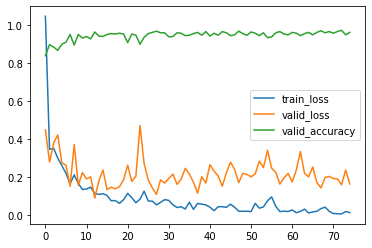

In [50]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqCycleShift

In [51]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqCycleShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
2.01779676080713
TEST
loss: 1.7737115142165973
accuracy: 0.4731182795698925
******************
epoch: 1
Train
1.4211617835953343
TEST
loss: 1.003159039379448
accuracy: 0.6989247311827957
******************
epoch: 2
Train
1.2650507445224974
TEST
loss: 0.6064942100996612
accuracy: 0.7956989247311828
******************
epoch: 3
Train
1.1578670830641886
TEST
loss: 0.48441247978518087
accuracy: 0.8451612903225807
******************
epoch: 4
Train
1.0877396222013391
TEST
loss: 0.44038792015403827
accuracy: 0.8688172043010752
******************
epoch: 5
Train
0.9947484555139167
TEST
loss: 0.6431491160905489
accuracy: 0.8021505376344086
******************
epoch: 6
Train
1.0467771328323685
TEST
loss: 0.4253278329808225
accuracy: 0.8838709677419355
******************
epoch: 7
Train
0.9490956077668123
TEST
loss: 0.8278295496458649
accuracy: 0.7978494623655914
******************
epoch: 8
Train
0.9888940532809634
TEST
loss: 0.4094901750485102
accuracy: 0

In [52]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9259896729776248


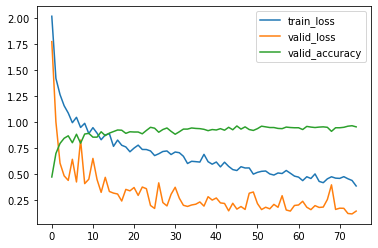

In [53]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSpecialShift

In [54]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9912047426612004
TEST
loss: 0.4070722967065791
accuracy: 0.8774193548387097
******************
epoch: 1
Train
0.3562953381302155
TEST
loss: 0.28418983579963764
accuracy: 0.9139784946236559
******************
epoch: 2
Train
0.32599310831286665
TEST
loss: 0.543364151318868
accuracy: 0.843010752688172
******************
epoch: 3
Train
0.2795001233721781
TEST
loss: 0.3318750226369468
accuracy: 0.8709677419354839
******************
epoch: 4
Train
0.24516702558510267
TEST
loss: 0.2660032371840169
accuracy: 0.9225806451612903
******************
epoch: 5
Train
0.25013066647703697
TEST
loss: 0.3476360224908398
accuracy: 0.896774193548387
******************
epoch: 6
Train
0.19518244189476544
TEST
loss: 0.19818185418844222
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.1555545645945003
TEST
loss: 0.22102618787878303
accuracy: 0.9397849462365592
******************
epoch: 8
Train
0.1784898453042529
TEST
loss: 0.23341436358669432
accur

In [55]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


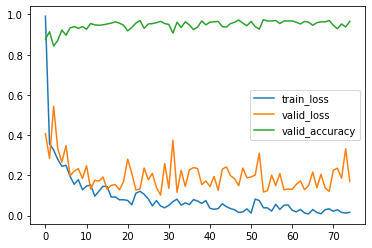

In [56]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSpecialShift

In [57]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSpecialShift', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.9867253551960762
TEST
loss: 2.038504022167575
accuracy: 0.5655913978494623
******************
epoch: 1
Train
1.3605066794635277
TEST
loss: 0.6997792966904178
accuracy: 0.7806451612903226
******************
epoch: 2
Train
1.255033401372167
TEST
loss: 0.788033837400457
accuracy: 0.7698924731182796
******************
epoch: 3
Train
1.1332455354155426
TEST
loss: 0.7818414611201132
accuracy: 0.789247311827957
******************
epoch: 4
Train
1.0699811441383507
TEST
loss: 0.46246758866053755
accuracy: 0.8473118279569892
******************
epoch: 5
Train
0.9532248123910521
TEST
loss: 0.5146381916538362
accuracy: 0.8688172043010752
******************
epoch: 6
Train
1.0018756347249513
TEST
loss: 0.4485831747772873
accuracy: 0.8774193548387097
******************
epoch: 7
Train
0.9379064540549767
TEST
loss: 0.30251436220702305
accuracy: 0.896774193548387
******************
epoch: 8
Train
0.9400835220827874
TEST
loss: 0.4120799877310312
accuracy: 0.8

In [58]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9259896729776248


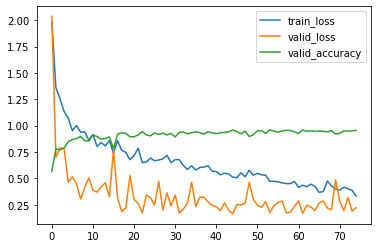

In [59]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeSwapAugmentation

In [60]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8877849329782547
TEST
loss: 0.4427996818256634
accuracy: 0.8688172043010752
******************
epoch: 1
Train
0.322343614772885
TEST
loss: 0.42852018039713624
accuracy: 0.8709677419354839
******************
epoch: 2
Train
0.29821184352963087
TEST
loss: 0.43275235176727334
accuracy: 0.8903225806451613
******************
epoch: 3
Train
0.23030928429667513
TEST
loss: 0.45197138453042635
accuracy: 0.8838709677419355
******************
epoch: 4
Train
0.2240357104815266
TEST
loss: 0.5172019709822953
accuracy: 0.8451612903225807
******************
epoch: 5
Train
0.1633084529371883
TEST
loss: 0.3245094809480893
accuracy: 0.886021505376344
******************
epoch: 6
Train
0.15833415820448388
TEST
loss: 0.4089164755036754
accuracy: 0.9010752688172043
******************
epoch: 7
Train
0.20177944230420267
TEST
loss: 0.4321933481641995
accuracy: 0.8989247311827957
******************
epoch: 8
Train
0.13142523886089244
TEST
loss: 0.13032061367706266
acc

In [61]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


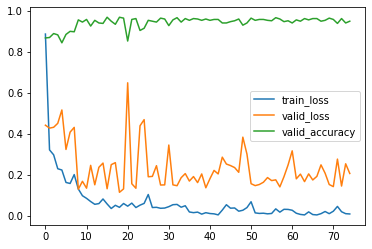

In [62]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqSwapAugmentation

In [63]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqSwapAugmentation', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.0227086965795096
TEST
loss: 0.6203503190509735
accuracy: 0.8
******************
epoch: 1
Train
0.4230087850770452
TEST
loss: 0.2698501338881831
accuracy: 0.9053763440860215
******************
epoch: 2
Train
0.3217825544862639
TEST
loss: 0.6376010043646699
accuracy: 0.810752688172043
******************
epoch: 3
Train
0.25799600793651567
TEST
loss: 0.5163079488661981
accuracy: 0.8516129032258064
******************
epoch: 4
Train
0.26608222103529744
TEST
loss: 0.42650229815513857
accuracy: 0.8946236559139785
******************
epoch: 5
Train
0.24920794051632036
TEST
loss: 0.5226333455372882
accuracy: 0.8408602150537634
******************
epoch: 6
Train
0.29282174048785825
TEST
loss: 0.28374107731005516
accuracy: 0.9247311827956989
******************
epoch: 7
Train
0.2035213147255446
TEST
loss: 0.22228086186993506
accuracy: 0.9268817204301075
******************
epoch: 8
Train
0.17246502474167041
TEST
loss: 0.1242981444999215
accuracy: 0.963440

In [64]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9500860585197934


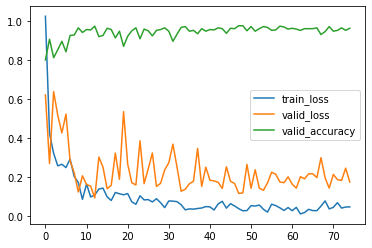

In [65]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeReplyMasking

In [66]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8956949334665852
TEST
loss: 0.45144354329314285
accuracy: 0.8580645161290322
******************
epoch: 1
Train
0.38563696103642947
TEST
loss: 0.24941413255148037
accuracy: 0.9118279569892473
******************
epoch: 2
Train
0.24774689634576816
TEST
loss: 0.21773851779840325
accuracy: 0.9204301075268817
******************
epoch: 3
Train
0.2356197794134025
TEST
loss: 0.8096354043611916
accuracy: 0.7784946236559139
******************
epoch: 4
Train
0.23484307537171298
TEST
loss: 0.27710331037480346
accuracy: 0.9096774193548387
******************
epoch: 5
Train
0.20515475002873246
TEST
loss: 0.2948808253852911
accuracy: 0.9204301075268817
******************
epoch: 6
Train
0.1359239754075958
TEST
loss: 0.1596738303120258
accuracy: 0.9440860215053763
******************
epoch: 7
Train
0.13818786276818348
TEST
loss: 0.2088309254056664
accuracy: 0.9290322580645162
******************
epoch: 8
Train
0.122443832693783
TEST
loss: 0.2698270881688723
ac

In [67]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9466437177280551


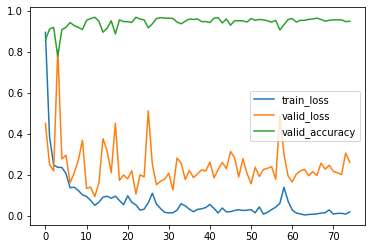

In [68]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqReplyMasking

In [69]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqReplyMasking', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.8990319960850441
TEST
loss: 0.3965879760922924
accuracy: 0.8666666666666667
******************
epoch: 1
Train
0.34627780778856126
TEST
loss: 0.3185554414667109
accuracy: 0.8924731182795699
******************
epoch: 2
Train
0.34579288015843207
TEST
loss: 0.3201750619437105
accuracy: 0.896774193548387
******************
epoch: 3
Train
0.2772003987269435
TEST
loss: 0.4911020839406598
accuracy: 0.886021505376344
******************
epoch: 4
Train
0.28103595545167365
TEST
loss: 0.4242802646852309
accuracy: 0.8516129032258064
******************
epoch: 5
Train
0.2502569931453444
TEST
loss: 0.3926347006472849
accuracy: 0.9096774193548387
******************
epoch: 6
Train
0.20058796247071198
TEST
loss: 0.1866780798922303
accuracy: 0.9311827956989247
******************
epoch: 7
Train
0.159742007163435
TEST
loss: 0.21303842175070958
accuracy: 0.9333333333333333
******************
epoch: 8
Train
0.14280566346857199
TEST
loss: 0.20705110010120176
accura

In [70]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9432013769363167


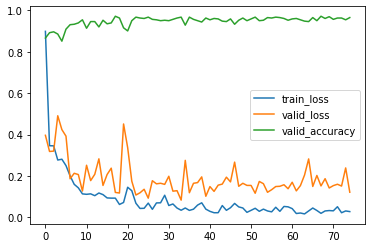

In [71]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### TimeRandomSwap

In [72]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'TimeRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
0.9999479382796896
TEST
loss: 0.3814926111890424
accuracy: 0.8666666666666667
******************
epoch: 1
Train
0.38958139036314166
TEST
loss: 0.4570693417902916
accuracy: 0.8387096774193549
******************
epoch: 2
Train
0.34830536422513797
TEST
loss: 0.2297868026200161
accuracy: 0.9118279569892473
******************
epoch: 3
Train
0.2686530046714655
TEST
loss: 0.3762040195926543
accuracy: 0.8881720430107527
******************
epoch: 4
Train
0.1965293847204988
TEST
loss: 0.2854134680763368
accuracy: 0.9182795698924732
******************
epoch: 5
Train
0.17795458569215972
TEST
loss: 0.3759851379139769
accuracy: 0.9075268817204301
******************
epoch: 6
Train
0.25507398131847636
TEST
loss: 0.19798459190955406
accuracy: 0.9333333333333333
******************
epoch: 7
Train
0.14463994494354976
TEST
loss: 0.8005748338596795
accuracy: 0.8150537634408602
******************
epoch: 8
Train
0.16221939068233446
TEST
loss: 0.6958223795698535
acc

In [73]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9363166953528399


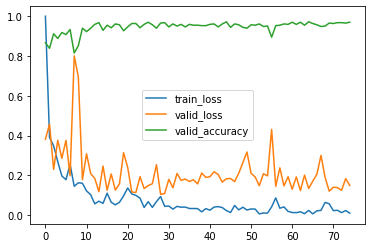

In [74]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

### FreqRandomSwap

In [75]:
seed_everything(random_seed)

train_dataset = AudioMNIST(mode='train', data = data, labels = labels, augment = True, aug_type = 'FreqRandomSwap', keys = train_keys)
valid_dataset = AudioMNIST(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = AudioMNIST(mode='test', data = data, labels = labels, keys = test_keys)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 10)
model = model.to(device)

epochs = 75
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model, train_losses, valid_losses, valid_acc = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

setting everything to seed 23
epoch: 0
Train
1.4078273024042898
TEST
loss: 0.5769208560707748
accuracy: 0.8129032258064516
******************
epoch: 1
Train
0.5527845516471883
TEST
loss: 0.34348571877325734
accuracy: 0.8709677419354839
******************
epoch: 2
Train
0.48213088955363087
TEST
loss: 0.34223226658118666
accuracy: 0.9010752688172043
******************
epoch: 3
Train
0.4094084724984505
TEST
loss: 0.5633991062000233
accuracy: 0.8279569892473119
******************
epoch: 4
Train
0.39423509355379677
TEST
loss: 0.5980455727987392
accuracy: 0.8473118279569892
******************
epoch: 5
Train
0.31790200849983985
TEST
loss: 0.7010107544801568
accuracy: 0.8
******************
epoch: 6
Train
0.30606887664086213
TEST
loss: 0.24620129884250702
accuracy: 0.9161290322580645
******************
epoch: 7
Train
0.22929995195257066
TEST
loss: 0.47401963632593874
accuracy: 0.8559139784946237
******************
epoch: 8
Train
0.2449632102225375
TEST
loss: 0.15183821987080318
accuracy: 0.944

In [76]:
evaluate(model, test_dataloader)

Quality of the model
accuracy: 0.9483648881239243


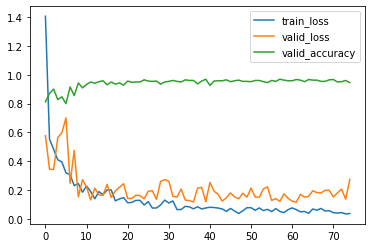

In [77]:
plt.plot(np.arange(epochs), train_losses, label = 'train_loss')
plt.plot(np.arange(epochs), valid_losses, label = 'valid_loss')
plt.plot(np.arange(epochs), valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()